In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [4]:
!nvidia-smi

Sun May 31 09:20:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Data

In [0]:
path_train = '/content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/valid/'
path_valid = '/content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/100/'
batch_size = 50

In [0]:
trainset = torchvision.datasets.ImageFolder(root = path_train,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((224,224)),
                                                                                          transforms.ToTensor()]))
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((224,224)),
                                                                                          transforms.ToTensor()]))
train_iter = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=True)

In [7]:
tgtnames = trainset.classes
tgtnames

['normal', 'not_normal', 'opacity']

In [8]:
validset

Dataset ImageFolder
    Number of datapoints: 300
    Root location: /content/drive/My Drive/Data/kaggle/rsna2019/rsna2019/4500_256/100/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

## Architecture 1: Alexnet 

In [0]:
# setting hyper-parameters
learning_rate = 0.05
num_epochs = 80
num_workers = 0


In [10]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
alexnet = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Flatten(),
            nn.Dropout(p=0.5,inplace=True),
            nn.Linear(in_features=6400,out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(p=0.5,inplace=True),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096,out_features=3)
            )
alexnet

Sequential(
  (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten()
  (14): Dropout(p=0.5, inplace=True)
  (15): Linear(in_features=6400, out_features=4096, bias=True)
  (16): ReLU()
  (17): Dropout2d(p=0.5, inplace=True)
  (18): Linear(in_features=4096, out_features=4096, bias=True)
 

In [0]:
torch.nn.init.xavier_uniform_(alexnet[0].weight)
torch.nn.init.xavier_uniform_(alexnet[3].weight)
torch.nn.init.xavier_uniform_(alexnet[6].weight)
torch.nn.init.xavier_uniform_(alexnet[8].weight)
torch.nn.init.xavier_uniform_(alexnet[10].weight)
torch.nn.init.xavier_uniform_(alexnet[15].weight)
torch.nn.init.xavier_uniform_(alexnet[18].weight)
torch.nn.init.xavier_uniform_(alexnet[20].weight)

alexnet = alexnet.to(device)


# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(alexnet.parameters(),lr=learning_rate) # sgd

## Train Network

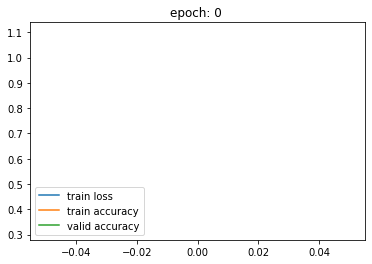

train loss:  1.100213114420573
train accuracy:  0.3186666667461395
valid accuracy:  0.36666667461395264


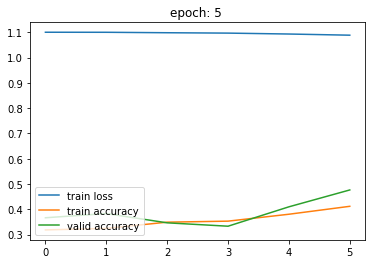

train loss:  1.0885754903157552
train accuracy:  0.41200000047683716
valid accuracy:  0.476666659116745


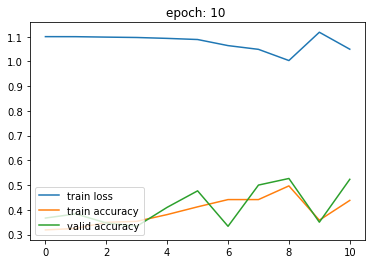

train loss:  1.0493740081787108
train accuracy:  0.43799999356269836
valid accuracy:  0.5233333110809326


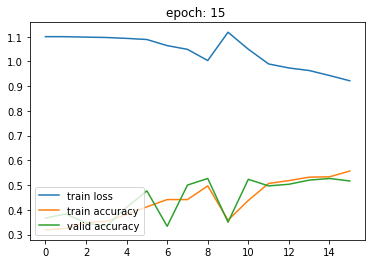

train loss:  0.9217221577962239
train accuracy:  0.5566666722297668
valid accuracy:  0.5166666507720947


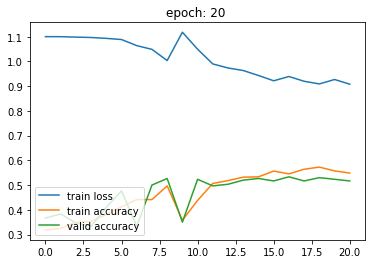

train loss:  0.9079900741577148
train accuracy:  0.5486666560173035
valid accuracy:  0.5166666507720947


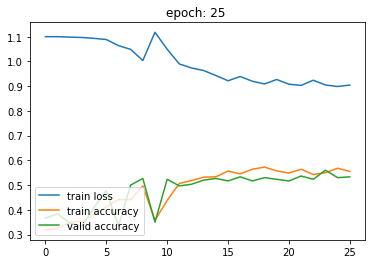

train loss:  0.9043641408284505
train accuracy:  0.5553333163261414
valid accuracy:  0.5333333611488342


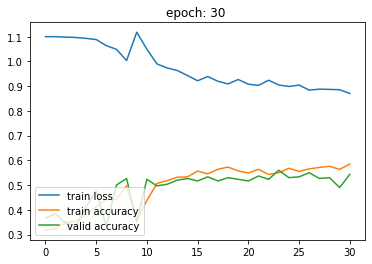

train loss:  0.8702498118082682
train accuracy:  0.5853333473205566
valid accuracy:  0.5433333516120911


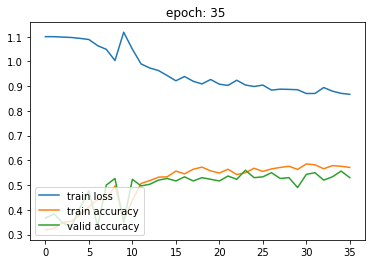

train loss:  0.8670403162638346
train accuracy:  0.5713333487510681
valid accuracy:  0.5299999713897705


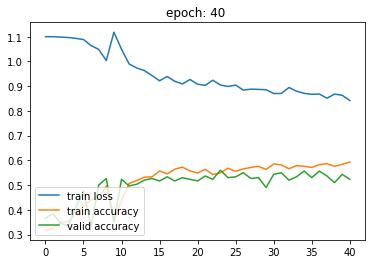

train loss:  0.8419610977172851
train accuracy:  0.5933333039283752
valid accuracy:  0.5233333110809326


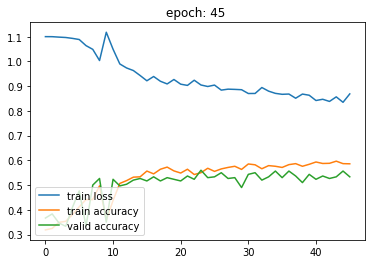

train loss:  0.868692143758138
train accuracy:  0.5860000252723694
valid accuracy:  0.5333333611488342


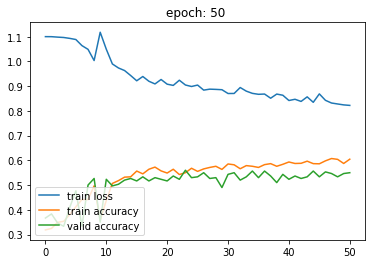

train loss:  0.8221765518188476
train accuracy:  0.6046666502952576
valid accuracy:  0.550000011920929


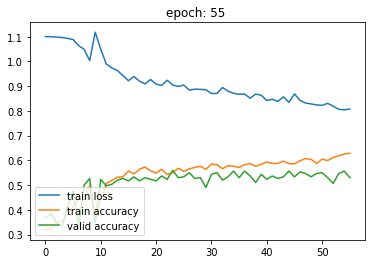

train loss:  0.8074247360229492
train accuracy:  0.6286666393280029
valid accuracy:  0.5299999713897705


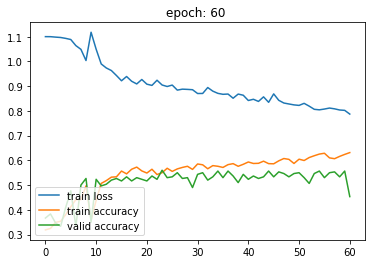

train loss:  0.787034289042155
train accuracy:  0.6313333511352539
valid accuracy:  0.4533333480358124


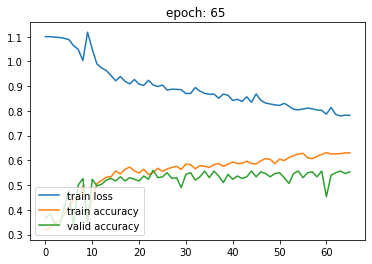

train loss:  0.7815991083780924
train accuracy:  0.6306666731834412
valid accuracy:  0.5533333420753479


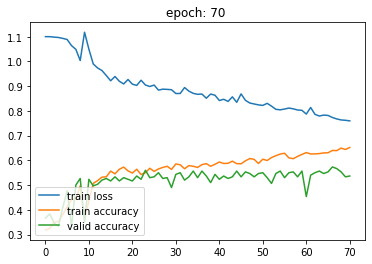

train loss:  0.7597089767456054
train accuracy:  0.6520000100135803
valid accuracy:  0.5366666913032532


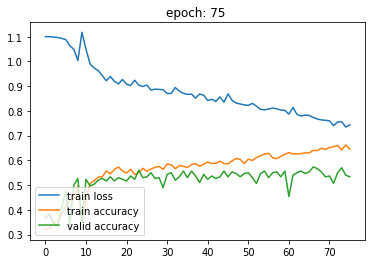

train loss:  0.7432196935017904
train accuracy:  0.6453333497047424
valid accuracy:  0.5333333611488342


In [12]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device)
    y_hat=alexnet(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset)))

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = alexnet(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset)))


  if epoch%5 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

## Display 1st minibatch's results


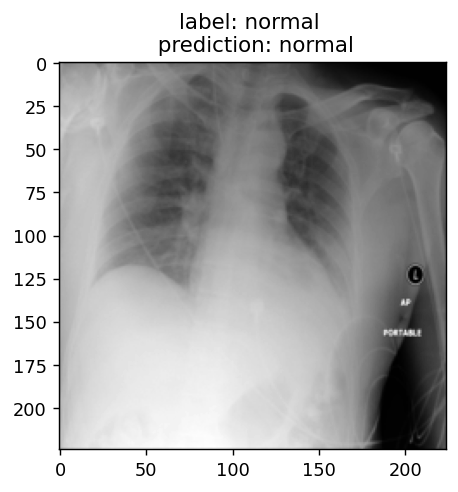

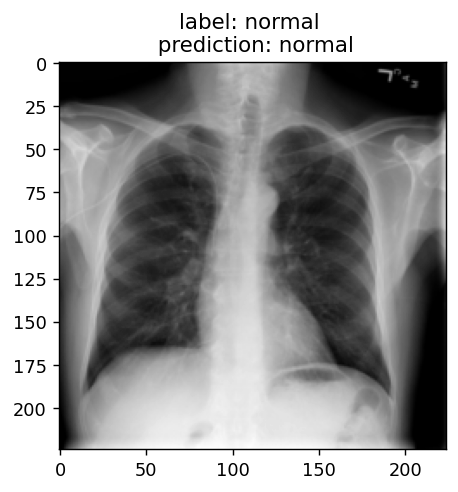

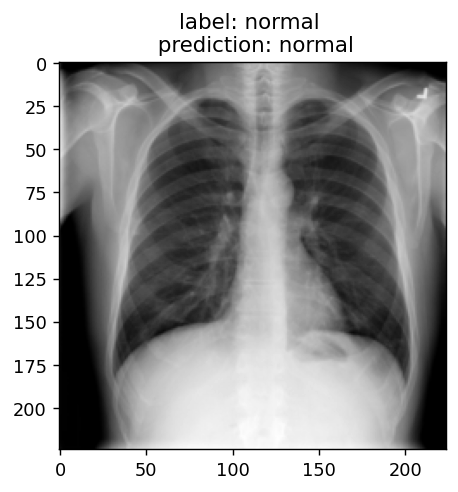

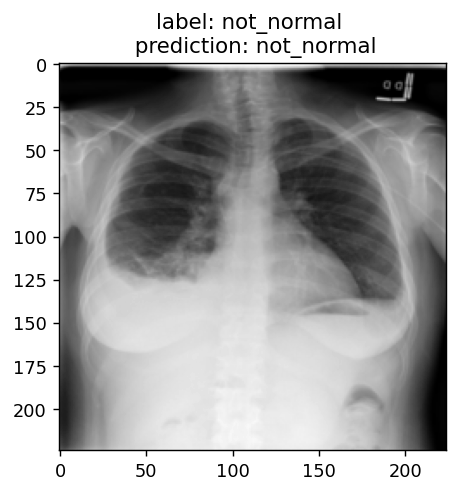

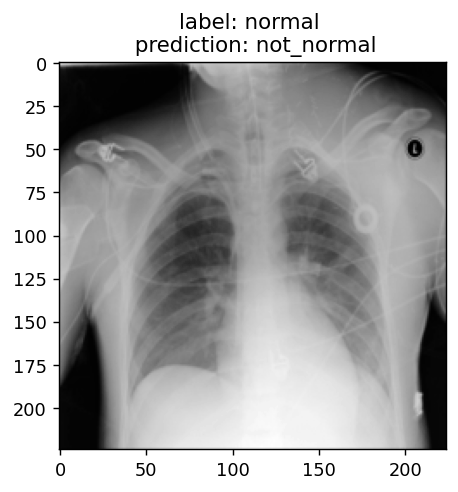

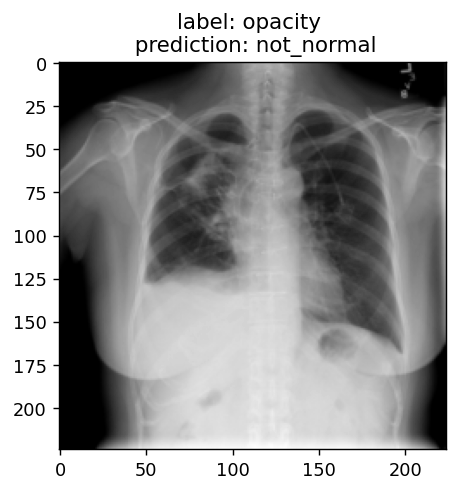

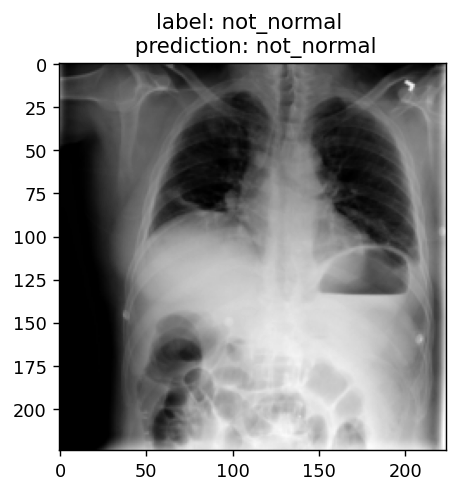

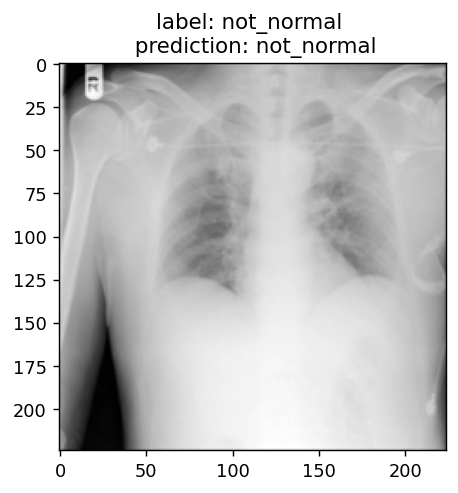

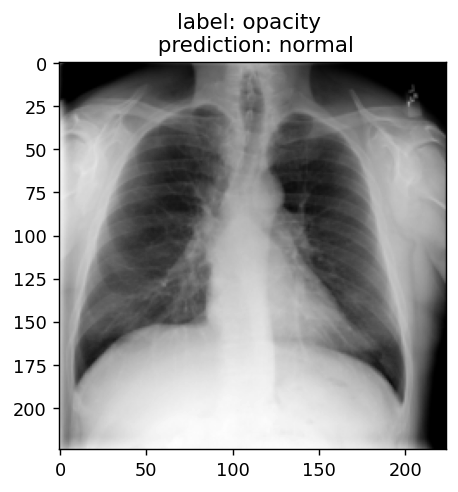

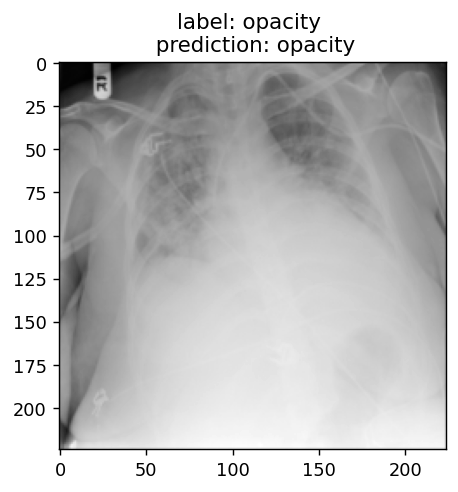

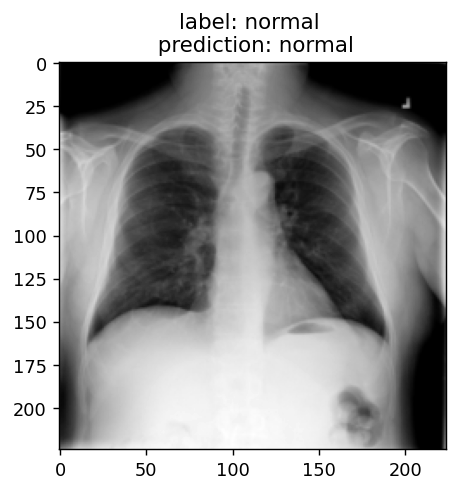

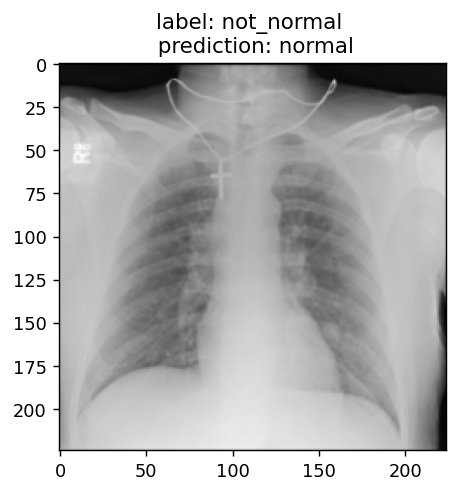

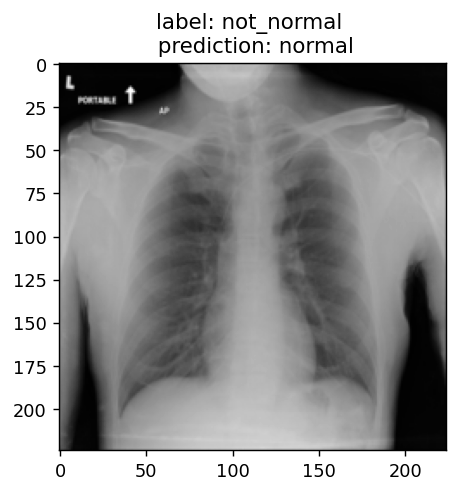

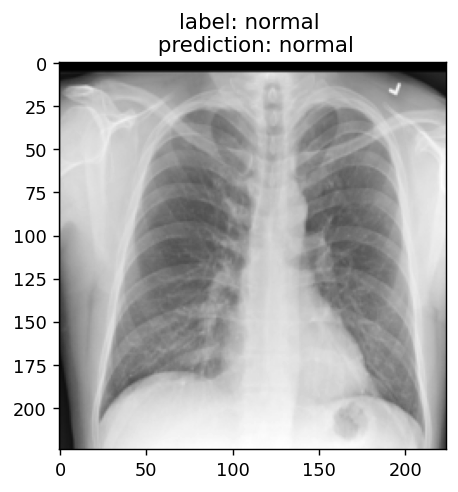

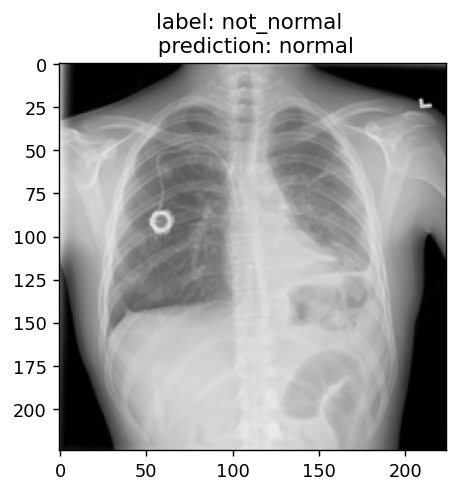

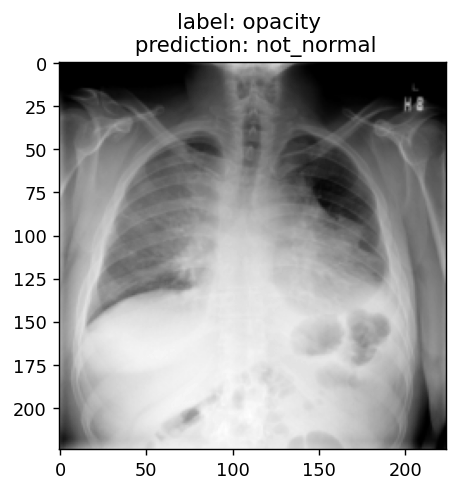

In [13]:
i = 0
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = alexnet(X)    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.figure(dpi=128)
    plt.imshow(X[n].cpu().squeeze(),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
    plt.pause(.0001)
  if i>1:
     break

## Architecture 2: VGG

In [0]:
# setting hyper-parameters
learning_rate = 0.05
num_epochs = 80
num_workers = 0

In [0]:
def vgg_block(num_convs, in_channels, out_channels):
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    
    blk = nn.Sequential(*layers)
    
    return blk

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
def vgg(conv_arch):
    # The convulational layer part
    conv_layers=[]
    in_channels=1
    
    for (num_convs, out_channels) in conv_arch:
        conv_layers.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    net=nn.Sequential(
                      *conv_layers,
                      # The fully connected layer part
                      Flatten(),
                      nn.Linear(in_features=512*7*7, out_features=4096),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(4096, 4096),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(4096, 3)
                     )
    return net

In [17]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
vggnet = vgg(conv_arch)
vggnet

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [0]:
torch.nn.init.xavier_uniform_(vggnet[0][0].weight)

torch.nn.init.xavier_uniform_(vggnet[1][0].weight)

torch.nn.init.xavier_uniform_(vggnet[2][0].weight)
torch.nn.init.xavier_uniform_(vggnet[2][2].weight)

torch.nn.init.xavier_uniform_(vggnet[3][0].weight)
torch.nn.init.xavier_uniform_(vggnet[3][2].weight)

torch.nn.init.xavier_uniform_(vggnet[4][0].weight)
torch.nn.init.xavier_uniform_(vggnet[4][2].weight)

torch.nn.init.xavier_uniform_(vggnet[6].weight)
torch.nn.init.xavier_uniform_(vggnet[9].weight)
torch.nn.init.xavier_uniform_(vggnet[12].weight)

vggnet = vggnet.to(device)

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(vggnet.parameters(),lr=learning_rate) # sgd

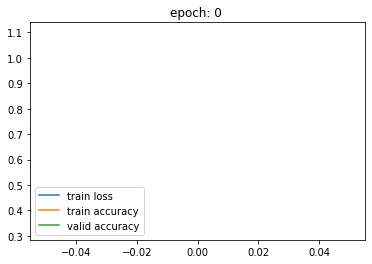

train loss:  1.1006389617919923
train accuracy:  0.3233333230018616
valid accuracy:  0.3733333349227905


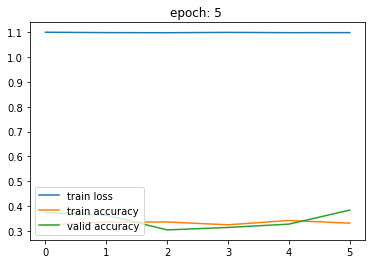

train loss:  1.0991366068522135
train accuracy:  0.3306666612625122
valid accuracy:  0.38333332538604736


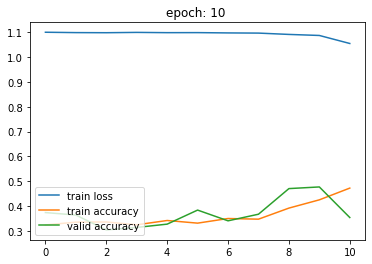

train loss:  1.0552879969278972
train accuracy:  0.47200000286102295
valid accuracy:  0.35333332419395447


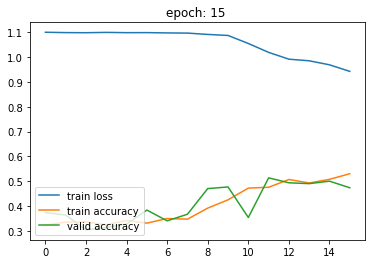

train loss:  0.9427557627360026
train accuracy:  0.5299999713897705
valid accuracy:  0.47333332896232605


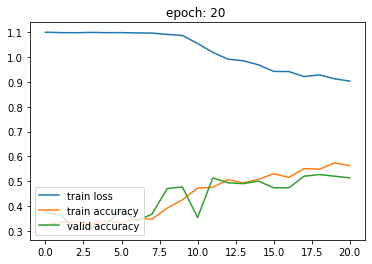

train loss:  0.903300666809082
train accuracy:  0.562666654586792
valid accuracy:  0.5133333206176758


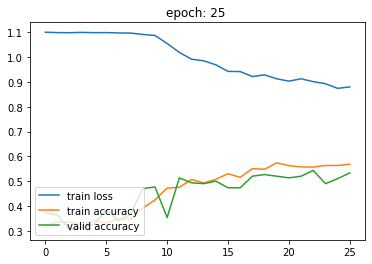

train loss:  0.880136235555013
train accuracy:  0.5680000185966492
valid accuracy:  0.5333333611488342


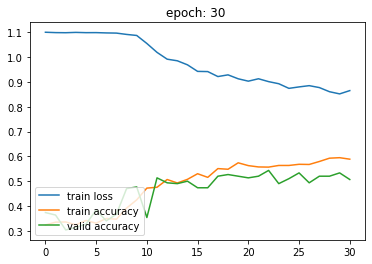

train loss:  0.8652177810668945
train accuracy:  0.5886666774749756
valid accuracy:  0.5066666603088379


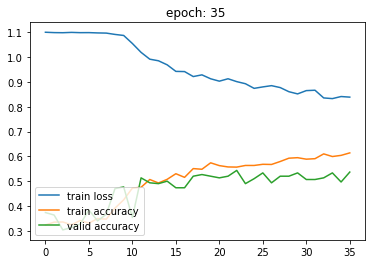

train loss:  0.8389211018880208
train accuracy:  0.6140000224113464
valid accuracy:  0.5366666913032532


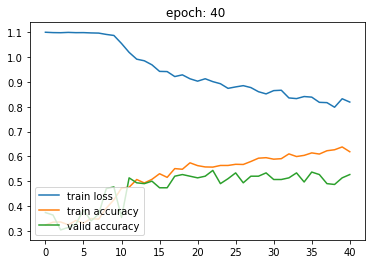

train loss:  0.8189844767252604
train accuracy:  0.6186666488647461
valid accuracy:  0.5266666412353516


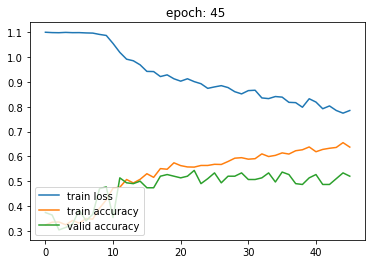

train loss:  0.7849754333496094
train accuracy:  0.637333333492279
valid accuracy:  0.5199999809265137


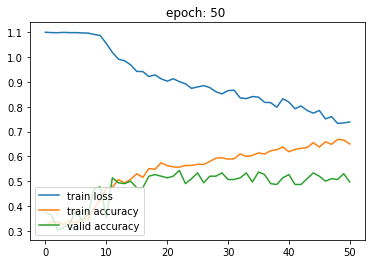

train loss:  0.7388938268025717
train accuracy:  0.6499999761581421
valid accuracy:  0.49666666984558105


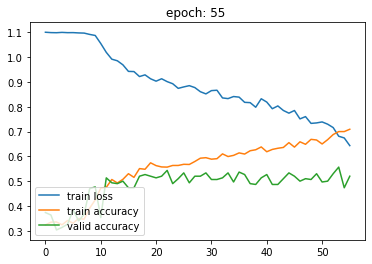

train loss:  0.6433455785115559
train accuracy:  0.7093333601951599
valid accuracy:  0.5199999809265137


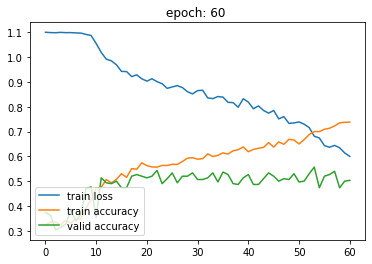

train loss:  0.5999160130818685
train accuracy:  0.7379999756813049
valid accuracy:  0.503333330154419


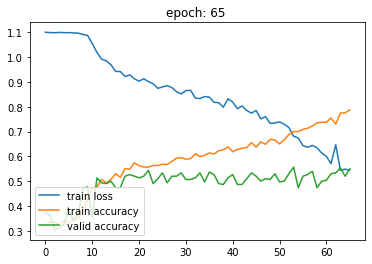

train loss:  0.5438062032063802
train accuracy:  0.7873333096504211
valid accuracy:  0.550000011920929


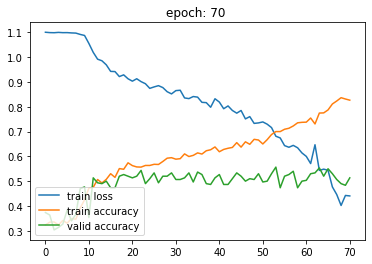

train loss:  0.44042081832885743
train accuracy:  0.8266666531562805
valid accuracy:  0.5133333206176758


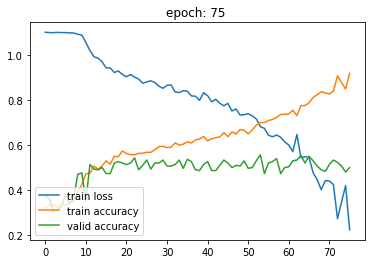

train loss:  0.22328446706136068
train accuracy:  0.9179999828338623
valid accuracy:  0.5


In [19]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device)
    y_hat=vggnet(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()  

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/np.float(len(trainset)))

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = vggnet(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
  accs_valid = np.append(accs_valid,correct.cpu()/np.float(len(validset)))


  if epoch%5 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

## Display 1st minibatch's results

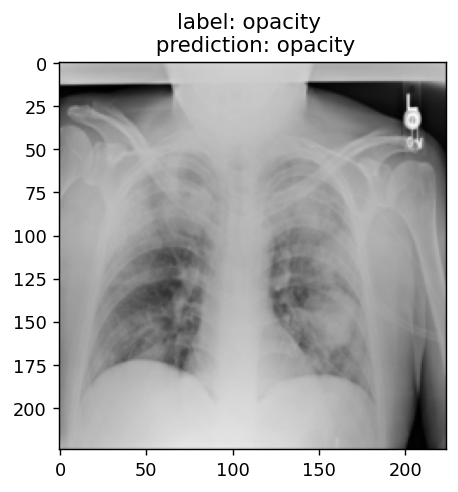

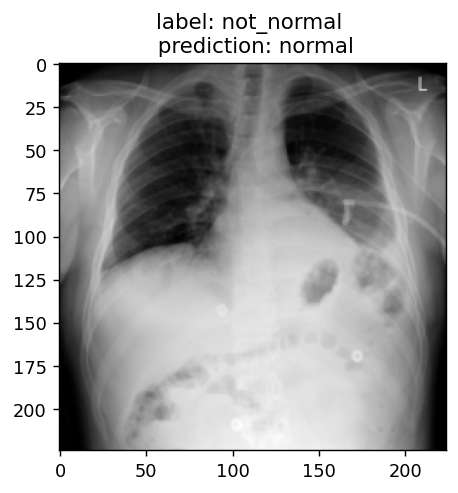

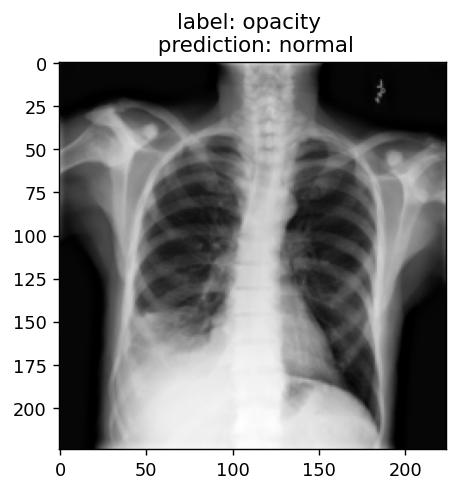

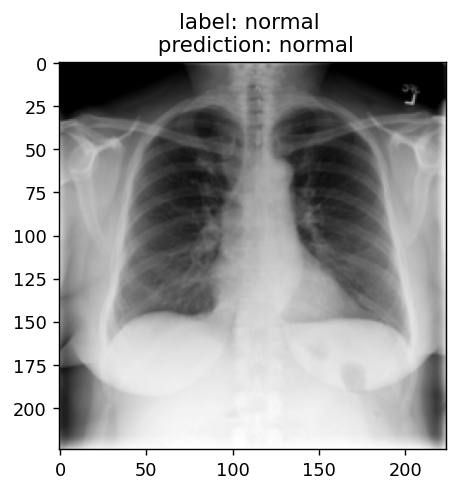

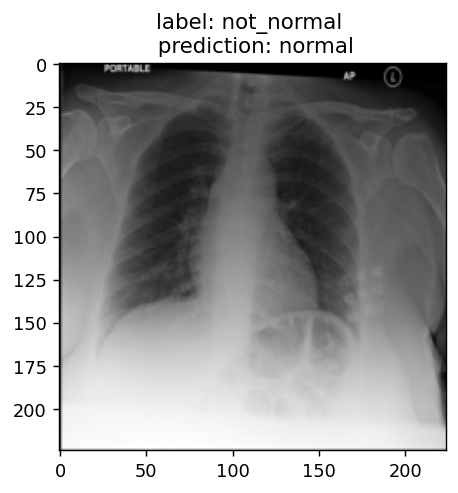

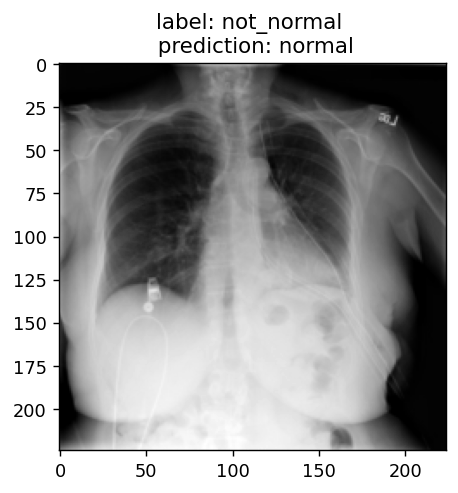

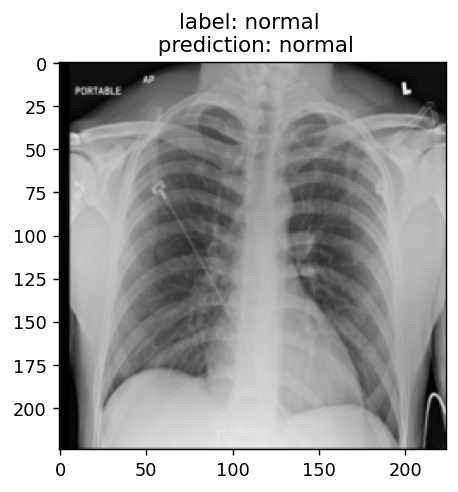

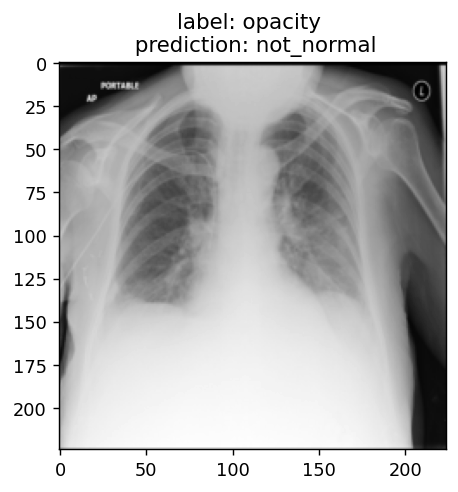

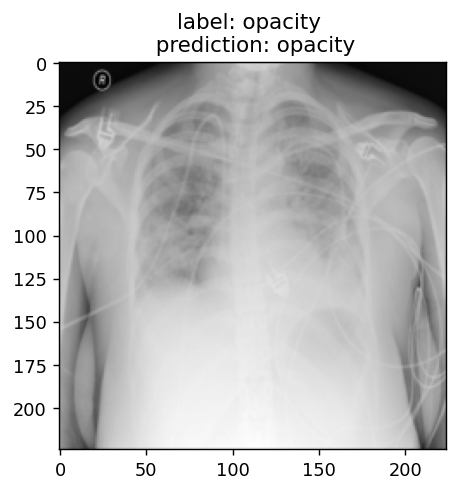

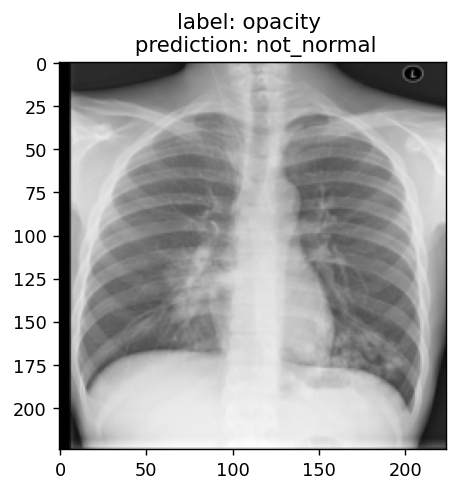

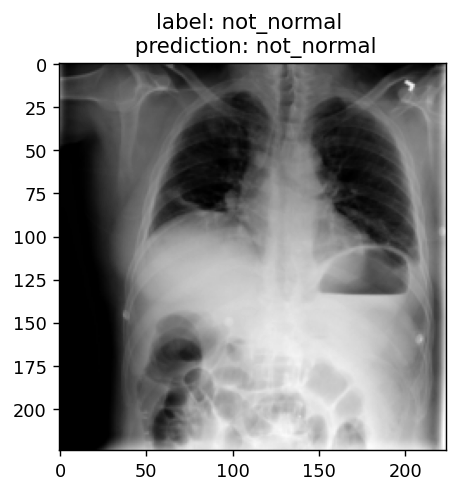

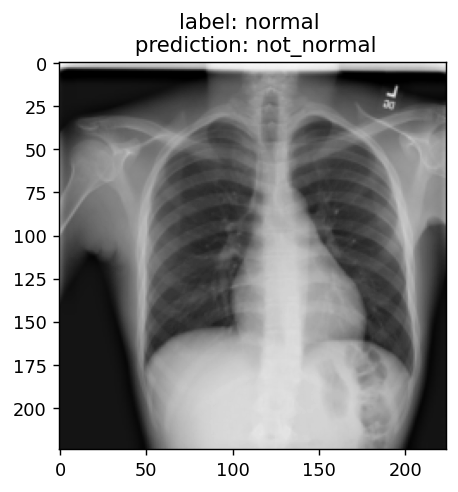

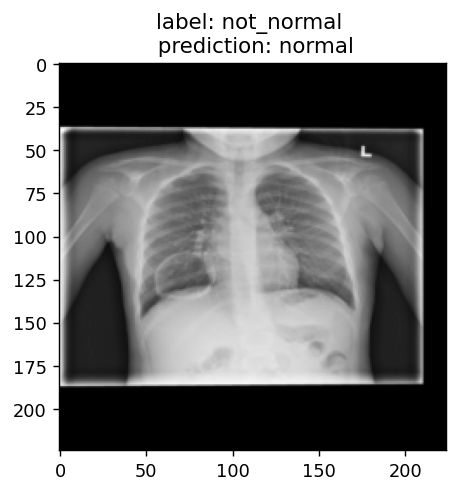

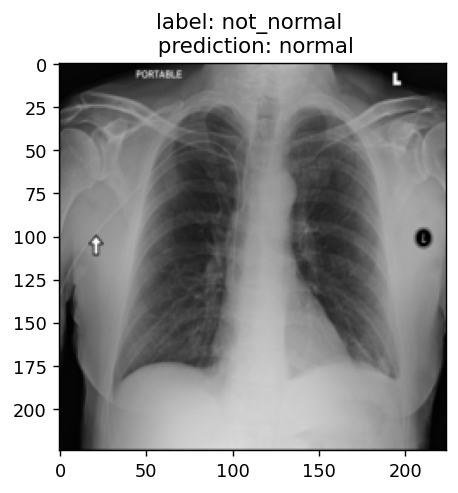

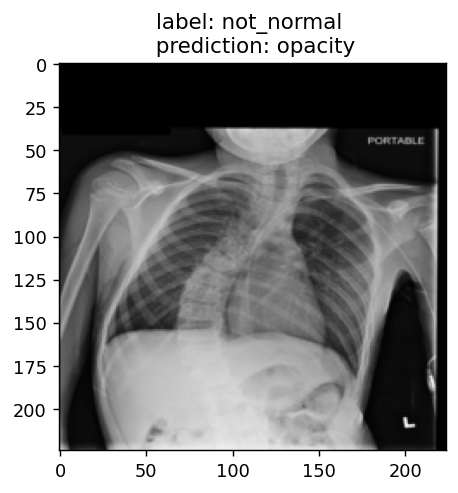

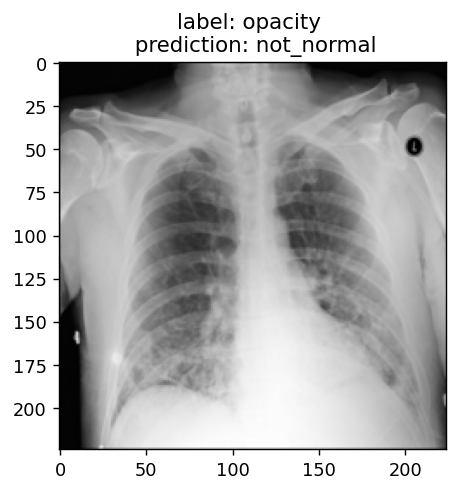

In [20]:
i = 0
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = vggnet(X)    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.figure(dpi=128)
    plt.imshow(X[n].cpu().squeeze(),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
    plt.pause(.0001)
  if i>1:
     break